In [8]:
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import gc
gc.collect()
torch.cuda.empty_cache()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_epochs = 2
batch_size = 30
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

cor_class_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(cifar_trainset
    , batch_size = batch_size
    , shuffle = True)
test_loader = torch.utils.data.DataLoader(cifar_testset
    , batch_size = batch_size
    , shuffle = True)

train_total_step = len(train_loader)
test_total_step = len(test_loader)
print(train_total_step, test_total_step)

cuda
Files already downloaded and verified
Files already downloaded and verified
1667 334


In [10]:
from tqdm import tqdm

In [14]:
model = torchvision.models.vgg19(pretrained = True)
input_lastLayer = model.classifier[6].in_features # last layer input num
model.classifier[6] = nn.Linear(input_lastLayer,10) # change last layer output
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                        lr = learning_rate, 
                        momentum=0.9,
                        weight_decay=5e-4)
H = {
	"train_loss": [],
	"train_acc": [],
	"test_loss": [],
	"test_acc": []
}

for epoch in range(num_epochs):
    # set the model in training mode
    model.train()
    total_train_loss = 0
    total_test_loss = 0
    train_correct = 0
    test_correct = 0
    # loop over the training set
    progress = tqdm(total=len(train_loader))
    for (x, y) in train_loader:
        progress.update(1)
		# send the input to the device
        (x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
        pred = model(x)
        loss = criterion(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        total_train_loss += loss
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in test_loader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = model(x)
            total_test_loss += criterion(pred, y)
            # calculate the number of correct predictions
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # calculate the average training and validation loss
    avg_train_loss = total_train_loss / train_total_step
    avg_test_loss = total_test_loss / test_total_step

    # calculate the training and validation accuracy
    train_correct = train_correct / len(train_loader.dataset)
    test_correct = test_correct / len(test_loader.dataset)

    # update our training history
    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["train_acc"].append(train_correct)
    H["test_loss"].append(avg_test_loss.cpu().detach().numpy())
    H["test_acc"].append(test_correct)

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, num_epochs))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avg_test_loss, test_correct))


91it [01:26,  1.05it/s]

100%|██████████| 1667/1667 [19:12<00:00,  1.53it/s]

[INFO] EPOCH: 1/2
Train loss: 0.412894, Train accuracy: 0.8596
Val loss: 0.232731, Val accuracy: 0.9198



100%|██████████| 1667/1667 [19:02<00:00,  1.51it/s]

[INFO] EPOCH: 2/2
Train loss: 0.203669, Train accuracy: 0.9309
Val loss: 0.262982, Val accuracy: 0.9121



In [17]:
print(H["train_loss"])
print(H["train_acc"])
print(H["test_loss"])
print(H["test_acc"])

[array(0.41289446, dtype=float32), array(0.20366871, dtype=float32)]
[0.85956, 0.93094]
[array(0.23273088, dtype=float32), array(0.26298198, dtype=float32)]
[0.9198, 0.9121]


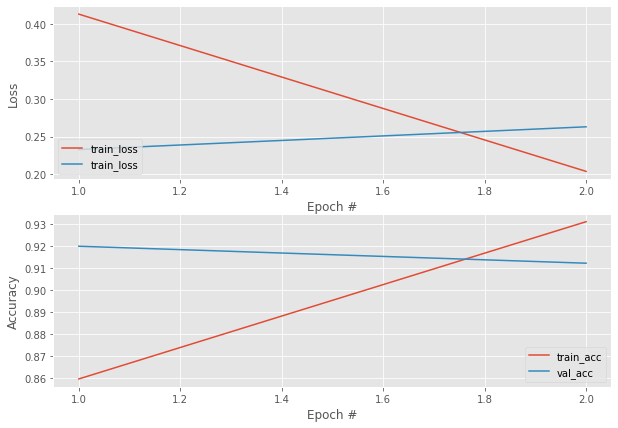

In [33]:
import matplotlib.pyplot as plt

# plot the training loss and accuracy
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2,2,(1,2))
plt.style.use("ggplot")

plt.plot(range(1, len(H["train_loss"]) + 1), H["train_loss"], label="train_loss")
plt.plot(range(1, len(H["test_loss"]) + 1), H["test_loss"], label="train_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

fig.add_subplot(2,2,(3,4))
plt.plot(range(1, len(H["train_acc"]) + 1), H["train_acc"], label="train_acc")
plt.plot(range(1, len(H["test_acc"]) + 1), H["test_acc"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")

plt.savefig('la.png')
plt.show()

In [ ]:
# serialize the model to disk
torch.save(model, 'model_all.pt')

In [34]:
model = torch.load('model_all.pt')
model.eval()

In [35]:
from PIL import Image

In [53]:
img = Image.open('cat.jpg').convert('RGB').resize((224,224), Image.ANTIALIAS)
tfms = transforms.Compose([
        # transforms.Resize(224,224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# unsqueeze provides the batch dimension
img_tensor = tfms(img).to('cuda').unsqueeze(0)

output = model(img_tensor)
# # to binarize the output since I had only 1 class
output = (output.squeeze().cpu().detach().numpy())
print(output.argmax(axis=0))

cor_class_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(cor_class_list[output.argmax(axis=0)])

tensor([[ 0.1198, -4.0771, -2.7498, 18.6521, -1.8425,  3.8426, -2.3535, -3.0151,
         -3.1679, -6.6881]], device='cuda:0', grad_fn=<AddmmBackward0>)
3
cat
